In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data


from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print('devece:', device)
print('torch version:', torch.__version__)

import pandas as pd
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

cuda
True
devece: cuda
torch version: 2.0.1+cu117


In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [4]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [5]:
train, valid, test = load_data(params.model_name)

### Modeling

In [6]:
## TODO : 모듈 형식으로 모델 GATEWAY 함수 구성
## TODO : AUTO ML 넣어서 제일 좋은 성능을 Select하는 형식

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 2586, number of negative: 59825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 62411, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041435 -> initscore=-3.141311
[LightGBM] [Info] Start training from score -3.141311


### inference

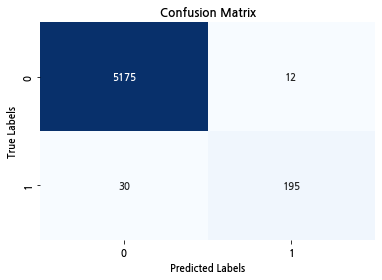

F1 Score: 0.9028
accuracy_score: 0.9922
precision_score: 0.9420
recall_score: 0.8667


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# Postprocessing

## 유민님 작업 공간

# Prescriptor

## Simulated Annealing

In [9]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional
import pandas as pd
from ipypb import ipb

@dataclass
class OptimizationConfig:
    initial_temp: float = 1000.0
    cooling_rate: float = 0.999
    max_iterations: int = 10000
    neighbor_range_threshold: float = 0.5

class SimulatedAnnealing:
    def __init__(
        self,
        model,
        columns,
        config: OptimizationConfig = OptimizationConfig()
    ):
        self.model = model
        self.columns = columns
        self.config = config
        self.reset_parameters()

    def reset_parameters(self):
        """initialization"""
        self.best_solution = None
        self.best_energy = float('inf')
        self.current_solution = None
        self.current_energy = float('inf')
        self.init_solution = None
        self.init_energy = float('inf')

    def initialize_context(self, test_data: pd.DataFrame) -> pd.DataFrame:
        """context initialization"""
        initial_values = {
            'lower_mold_temp2': test_data['lower_mold_temp2'].mean(),
            'cast_pressure': test_data['cast_pressure'].mean(),
            'molten_temp': test_data['molten_temp'].mean()
        }
        
        df = test_data[self.columns.context_columns].copy()
        for col, val in initial_values.items():
            df[col] = val
            
        return df

    def objective_function(self, solution: np.ndarray, X_input: pd.DataFrame) -> float:
        """Objective function"""
        X_modified = X_input.copy()

        # 컬럼별로 다른 값을 더해줘야 함
        X_modified['lower_mold_temp2'] += solution.T[0]
        X_modified['cast_pressure'] += solution.T[1]
        X_modified['molten_temp'] += solution.T[2]
        return self.model.predict(X_modified).mean()

    def generate_neighbor(
        self, 
        current: np.ndarray, 
        temp: float, 
        initial_temp: float
    ) -> np.ndarray:
        """Neighbor generation"""
        neighbor_range = (temp / initial_temp) * 20
        return current + np.random.normal(-neighbor_range, neighbor_range, (len(current),3)) # 3개의 컬럼에 대해 노이즈 추가

    def optimize(
        self, 
        test_data: pd.DataFrame, 
        progress_callback: Optional[callable] = None
    ) -> Tuple[np.ndarray, float, np.ndarray, float]:

        """Optimization"""
        df = self.initialize_context(test_data)
        X_test = df[self.columns.input_columns]

        # 초기 해 설정
        self.current_solution = np.random.randint(-3, 3, (len(X_test),3)) # 3개의 컬럼에 대해 랜덤 초기값 설정
        self.current_energy = self.objective_function(self.current_solution, X_test)
        
        # 초기값 저장
        self.init_solution = self.current_solution.copy()
        self.init_energy = self.objective_function(self.init_solution, X_test)
        
        # 최적값 초기화
        self.best_solution = self.current_solution.copy()
        self.best_energy = self.init_energy
        
        temp = self.config.initial_temp

        for iteration in ipb(range(self.config.max_iterations)):
            # neighbor solution generation
            new_solution = self.generate_neighbor(
                self.current_solution, 
                temp, 
                self.config.initial_temp
            )
            new_energy = self.objective_function(new_solution, X_test)

            # neighbor solution accept
            neighbor_range = (temp / self.config.initial_temp) * 20
            if neighbor_range < self.config.neighbor_range_threshold:
                break

            # solution update
            if new_energy < self.current_energy:
                self.current_solution = new_solution
                self.current_energy = new_energy

                if self.current_energy < self.best_energy:
                    self.best_solution = self.current_solution.copy()
                    self.best_energy = self.current_energy
                    print(f'Best energy updated: {self.best_energy}')

            # temp cooling
            temp *= self.config.cooling_rate

            # callback
            if progress_callback:
                progress_callback(iteration, self.best_energy)

        return (
            self.init_solution,
            self.init_energy,
            self.best_solution,
            self.best_energy
        )
    

# callback function 
def progress_callback(iteration: int, best_energy: float):
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}: Best Energy = {best_energy}")

In [10]:
config = OptimizationConfig(
    initial_temp=1000,
    cooling_rate=0.999,
    max_iterations=10000,
    neighbor_range_threshold=0.5
)

optimizer = SimulatedAnnealing(model, columns, config)

init_solution, init_energy, best_solution, best_energy = optimizer.optimize(
    test,
    progress_callback=progress_callback
)

print(f"초기해: {init_solution}, 초기 에너지: {init_energy}")
print(f"최적해: {best_solution}, 최적 에너지: {best_energy}")

 [██████████████████████######################################] 3677/10000 [00:31<00:00, 0.01s/it]

Iteration 0: Best Energy = 0.01977087952697709
Iteration 1000: Best Energy = 0.01977087952697709
Iteration 2000: Best Energy = 0.01977087952697709
Iteration 3000: Best Energy = 0.01977087952697709
Best energy updated: 0.01958610495195861
초기해: [[ 2  1  2]
 [-3 -2 -2]
 [-3 -3 -1]
 ...
 [ 2  0 -1]
 [-3  0  0]
 [ 0  0 -1]], 초기 에너지: 0.01977087952697709
최적해: [[ 5.31348909e-04 -1.40604235e+00  4.56221440e-01]
 [-2.72858104e+00 -4.05738592e+00 -6.37748789e+00]
 [-2.78534693e+00 -4.05665052e+00 -1.69391941e+00]
 ...
 [-7.47428552e-01 -7.34917621e-02 -1.34633196e+00]
 [-4.78265763e+00 -4.28917573e-03 -8.30277800e-01]
 [ 3.88877984e-01 -8.43948872e-01 -1.54047078e+00]], 최적 에너지: 0.01958610495195861


In [11]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] += optimizer.best_solution.T[0]
X_test['cast_pressure'] += optimizer.best_solution.T[1]
X_test['molten_temp'] += optimizer.best_solution.T[2]

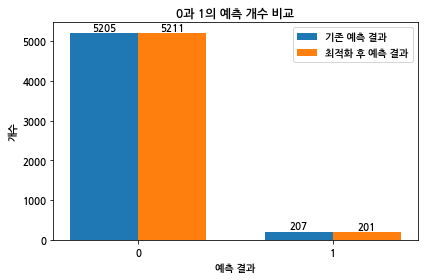

In [12]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Bayesian Optimization

In [13]:
from bayes_opt import BayesianOptimization

In [31]:
# bayesian optimization
def predictor_function(lower_mold_temp2, cast_pressure, molten_temp):
    X_test = test[columns.input_columns].copy()
    X_test['lower_mold_temp2'] = lower_mold_temp2
    X_test['cast_pressure'] = cast_pressure
    X_test['molten_temp'] = molten_temp
    return - model.predict(X_test).mean()

# Bounded region of parameter space
pbounds = {'lower_mold_temp2': (135, 333), 'cast_pressure': (300, 1000), 'molten_temp': (626, 735)}

optimizer = BayesianOptimization(
    f=predictor_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)


In [32]:
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

|   iter    |  target   | cast_p... | lower_... | molten... |
-------------------------------------------------------------
| 1         | -0.0146   | 591.9     | 277.6     | 626.0     |
| 2         | -0.02033  | 511.6     | 164.1     | 636.1     |
| 3         | -0.01737  | 430.4     | 203.4     | 669.2     |
| 4         | -0.01774  | 677.2     | 218.0     | 700.7     |
| 5         | -0.05562  | 443.1     | 308.9     | 629.0     |
| 6         | -0.02014  | 509.3     | 165.5     | 634.5     |
| 7         | -0.05562  | 682.6     | 309.9     | 626.0     |
| 8         | -0.017    | 591.9     | 225.8     | 671.9     |
| 9         | -0.03659  | 437.9     | 141.7     | 717.7     |
| 10        | -0.01534  | 541.9     | 241.2     | 631.1     |
| 11        | -0.02033  | 627.2     | 166.2     | 629.1     |
| 12        | -0.04564  | 655.0     | 151.3     | 734.3     |
| 13        | -0.01441  | 561.6     | 285.1     | 683.0     |
| 14        | -0.01718  | 518.3     | 230.2     | 702.6     |
| 15    

In [33]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] = optimizer.max['params']['lower_mold_temp2']
X_test['cast_pressure'] = optimizer.max['params']['cast_pressure']
X_test['molten_temp'] = optimizer.max['params']['molten_temp']


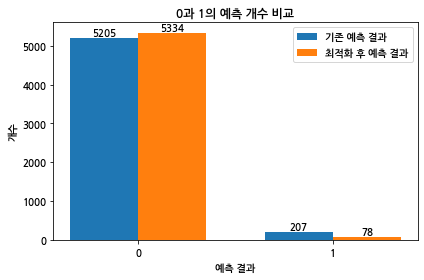

In [34]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
## Bayesian Optimization 하이퍼 파라미터 찾기

init_points: 3, n_iter: 10
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 20
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 30
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 40
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 50
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 5, n_iter: 10
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 20
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 30
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 40
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
i

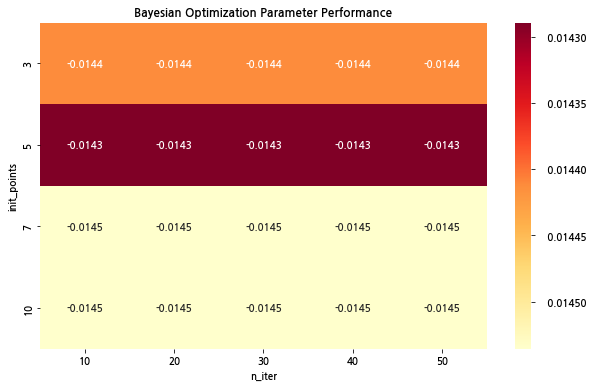

In [30]:
import numpy as np
from sklearn.model_selection import cross_val_score
from itertools import product

def evaluate_bo_params(init_points, n_iter, random_state=1):
    """
    주어진 init_points와 n_iter로 베이지안 최적화를 수행하고 결과를 평가
    """
    optimizer = BayesianOptimization(
        f=predictor_function,
        pbounds=pbounds,
        verbose=0,
        random_state=random_state
    )
    
    # 베이지안 최적화 수행
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )
    
    return optimizer.max['target']

# 탐색할 파라미터 범위 설정
init_points_range = [3, 5, 7, 10]
n_iter_range = [10, 20, 30, 40, 50]

# 결과를 저장할 딕셔너리
results = {}

# Grid Search 수행
for init_points, n_iter in product(init_points_range, n_iter_range):
    # 각 조합에 대해 여러 번 실행하여 평균 성능 계산
    scores = []
    for seed in range(3):  # 3번 반복
        score = evaluate_bo_params(init_points, n_iter, random_state=seed)
        scores.append(score)
    
    # 평균 성능 저장
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    results[(init_points, n_iter)] = (avg_score, std_score)
    
    print(f"init_points: {init_points}, n_iter: {n_iter}")
    print(f"Average Score: {avg_score:.4f} (±{std_score:.4f})")
    print("-" * 50)

# 최적의 파라미터 찾기
best_params = max(results.items(), key=lambda x: x[1][0])
print("\nBest Parameters:")
print(f"init_points: {best_params[0][0]}")
print(f"n_iter: {best_params[0][1]}")
print(f"Score: {best_params[1][0]:.4f} (±{best_params[1][1]:.4f})")

# 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 히트맵 데이터 준비
heatmap_data = np.zeros((len(init_points_range), len(n_iter_range)))
for i, init_points in enumerate(init_points_range):
    for j, n_iter in enumerate(n_iter_range):
        heatmap_data[i, j] = results[(init_points, n_iter)][0]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, 
            xticklabels=n_iter_range,
            yticklabels=init_points_range,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd')
plt.xlabel('n_iter')
plt.ylabel('init_points')
plt.title('Bayesian Optimization Parameter Performance')
plt.show()